
# **ATENÇÃO**
A lista deverá ser entregue tanto no formato .pdf e em .py ou .ipynb


# **Rotação de uma Imagem**
Uma opção seria utilizar a função de rotação do OpenCV. A ideia do exercício é não utilizar esta função, mas sim implementá-la manualmente (para compreender o que está ocorrendo nos bastidores). Para realizar este exercício, você deve preencher as lacunas da função escrita no código em anexo. Esta função tem como entrada:

.uma imagem (img),

.o ângulo de rotação (angulo),

.o centro de rotação (centro),

e devolve a imagem rotacionada.

In [1]:
import cv2 as cv
import sys
import numpy as np
from math import *
import matplotlib.pyplot as plt

In [2]:
def my_rotation(img, angulo, centro):

    # nessa primeira parte, vamos definir a transformação que leva a posicao dos pixels da imagem original
    # para a posicao dos pixels do imagem rotacionada.

    # a primeira matriz de translação muda a origem das coordenadas do canto da imagem para o centro da imagem
    matriz_translacao = np.array([
        [1, 0, -centro[0]],
        [0, 1, -centro[1]],
        [0, 0, 1],
    ])
    # a matriz de rotacao aplica a rotacao em torno da origem
    matriz_rotacao = np.array([
        [cos(angulo), -sin(angulo), 1],
        [sin(angulo), cos(angulo), 1],
        [0, 0, 1]
    ]) 
    # a composicao coloca todas as matrizes em uma só: aplica a translacao (muda a origem), rotaciona, volta para a origem anterior
    matriz_composicao = np.linalg.inv(matriz_translacao) @ matriz_rotacao @ matriz_translacao

    # criar imagem rotacionada em preto, com mesmas dimensões da original
    height, width = img.shape[:2]
    rotated_image = np.zeros((height,width,3), np.uint8)
    # o próximo passo é percorrer cada pixel da nova imagem e verificar qual é o pixel correspondente na imagem original
    m_comp_inv = np.linalg.inv(matriz_composicao)
    for linr in range(height):
        for colr in range(width):
            pos_rot = np.matrix([linr, colr, 1]).T
            pos_orig = m_comp_inv @ pos_rot
            lin = round(pos_orig[0,0]); col = round(pos_orig[1,0]);
            if (lin >=0 and lin < height) and (col >= 0 and col < width):
                #opa, é um pixel pertencente à imagem original...
                rotated_image[linr, colr] = img[lin,col]
    return rotated_image

In [3]:
img = cv.imread('Palazzo_Farnese_Fassade.jpg')
height, width = img.shape[:2]
centro = (height/2, width/2)
angulo = np.pi/6
my_rotated_image =  my_rotation(img, angulo, centro)

In [4]:
cv.imshow('Display window', my_rotated_image)
cv.waitKey(0); cv.destroyAllWindows()

Você pode comparar seu resultado com o função do Open CV.

In [5]:
# Obter o centro da imagem
height, width = img.shape[:2]
center = (width/2, height/2)

# Definir a matriz de rotação
M = cv.getRotationMatrix2D(center, 30, 1)

# Aplicar a rotação na imagem
rotated_img = cv.warpAffine(img, M, (width, height))

cv.imshow('Display window', rotated_img)
cv.waitKey(0); cv.destroyAllWindows()

# **Transformação Projetiva de uma Imagem**
Escreva uma função que tenha uma como entrada:

. uma imagem (img),

. uma matriz de uma transformação projetiva (T),

e devolva a imagem transformada.

A ideia é semelhante ao exercício 1, mas ao invés da rotação, temos uma transformação projetiva (homografia).

Teste a sua função, faça a transformação projetiva com apenas um ponto de fuga no eixo $x$ (digamos, o ponto $(2000,0)$ em coordenadas $x,y$), da imagem do Palazzo Farnese Fassade (em anexo).

Você pode usar outra imagem de sua preferência, caso queira. Não se esqueça de trabalhar com coordenadas homogênas.

In [ ]:
def my_transform(img, T):
    # Criando uma matriz de mesmas dimensões que a original porém totalmente preta
    height, width = img.shape[:2]
    transform_image = np.zeros((height, width, 3), np.uint8)
    inv_T = np.linalg.inv(T)
    for l in range(height):
        for c in range(width):
            pos_transformed = np.matrix([l, c, 1], dtype=np.float32).T
            pos_original = inv_T @ pos_transformed
            if pos_original[2] < 1e-10:
                continue
            pos_original /= pos_original[2]
            lin = round(pos_original[0,0]); col = round(pos_original[1,0]);
            if (lin >=0 and lin < height) and (col >= 0 and col < width):
                transform_image[l, c] = img[lin,col]
    return transform_image


In [9]:
T = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 1/2000, 1],
], dtype=np.float32)
img = cv.imread('Palazzo_Farnese_Fassade.jpg')
transform_image = my_transform(img,T)
cv.imshow('Display window', transform_image)
cv.waitKey(0); cv.destroyAllWindows()

# **Estimação da Transformação Projetiva**
**Crie uma função**

Escreva uma função que tenha uma como entrada:

. Quatro pontos “fonte” no plano projetivo, possivelmente impróprios,

. Quatro pontos “destino” no plano projetivo, possivelmente impróprios.

E devolva a transformação projetiva $T: \mathbb{R}\mathbb{P}^2 \rightarrow \mathbb{R}\mathbb{P}^2$ que leva os pontos “fonte” nos pontos
“destino”.

In [10]:
def my_estimation(lst1, lst2):
    A = np.array([[]]).reshape(0, 8)
    B = np.array([]).reshape(0, 1)
    for idx, p in enumerate(lst1):
        x = p[0]
        y = p[1]
        x1 = lst2[idx][0]   
        y1 = lst2[idx][1]
        A_pointArray = np.array([
            [x, y, 1, 0, 0, 0, -x * x1, -x1 * y],
            [0, 0, 0, x, y, 1, -y1 * x, -y1 * y],
            ])   
        B_pointArray = np.array([[x1], [y1]])
        B = np.vstack((B, B_pointArray))
        A = np.vstack((A, A_pointArray))

    solution = np.linalg.solve(A,B)
    solution = np.vstack([solution, [1]])    
    T_P = np.array(solution).reshape(3,3)
    return T_P
"""

def my_estimation(lst1, lst2):
    A = np.array([[]]).reshape(0, 8)
    B = np.array([]).reshape(0, 1)
    for idx, p in enumerate(lst1):
        y = p[0]
        x = p[1]
        y1 = lst2[idx][0]   
        x1 = lst2[idx][1]
        A_pointArray = np.array([
            [x, y, 1, 0, 0, 0, -x * x1, -x1 * y],
            [0, 0, 0, x, y, 1, -y1 * x, -y1 * y],
            ])   
        B_pointArray = np.array([[x1], [y1]])
        B = np.vstack((B, B_pointArray))
        A = np.vstack((A, A_pointArray))

    solution = np.linalg.solve(A,B)
    solution = np.vstack([solution, [1]])    
    T_P = np.array(solution).reshape(3,3)
    return T_P

"""







'\n\ndef my_estimation(lst1, lst2):\n    A = np.array([[]]).reshape(0, 8)\n    B = np.array([]).reshape(0, 1)\n    for idx, p in enumerate(lst1):\n        y = p[0]\n        x = p[1]\n        y1 = lst2[idx][0]   \n        x1 = lst2[idx][1]\n        A_pointArray = np.array([\n            [x, y, 1, 0, 0, 0, -x * x1, -x1 * y],\n            [0, 0, 0, x, y, 1, -y1 * x, -y1 * y],\n            ])   \n        B_pointArray = np.array([[x1], [y1]])\n        B = np.vstack((B, B_pointArray))\n        A = np.vstack((A, A_pointArray))\n\n    solution = np.linalg.solve(A,B)\n    solution = np.vstack([solution, [1]])    \n    T_P = np.array(solution).reshape(3,3)\n    return T_P\n\n'

Encontre a transformação projetiva que leva o campo de futebol da imagem
do gol no jogo Vasco contra Flamengo (em anexo) em um retângulo correspon-
dente ao campo de futebol visto de cima em projeção ortogonal (em anexo, mas
fique a vontade para usar outra). Para isso, utilize a sua função my_estimation.

Use esta projeção para desenhar o campo
de futebol visto de cima junto com a posição do Leo Pelé, do goleiro e de um
jogador do Flamengo. Para isso, utilize a sua função my_transform.

In [11]:
img_campo = cv.imread('Campo_Futebol.webp')
img_vasco_flamengo = cv.imread('Vasco_Flamengo.jpg')

lst1 = [
    [81, 174],
    [206, 89],
    [339, 205],
    [268, 425]
]

lst2 = [
    [43, 41],
    [155, 41],
    [258, 72],
    [207, 103]
]

"""
lst1 = [[80,173,1], 
        [144,616,1], 
        [206,89,1], 
        [339,204,1]]
lst2 = [[42,41,1],
        [94,133,1],
        [155,41,1],
        [258,71,1]]
"""
T_P = my_estimation(lst1=lst1, lst2=lst2)

In [12]:

transform_image = my_transform(img_vasco_flamengo, T_P )


In [13]:
cv.imshow('Display window', transform_image)
cv.waitKey(0); cv.destroyAllWindows()

In [24]:
def pintar_peh(img_campo, pos_jogadores):
    new_pos_jogadores = []
    circle_radious = 3
    for pos in pos_jogadores:
        nw = np.matrix([pos[0], pos[1], 1], dtype=np.float32).T
        nw = T_P @ nw
        new_pos_jogadores.append([int(nw[0]), int(nw[1])])
    
    img = img_campo.copy()
    for p in new_pos_jogadores:
        for i in range(-circle_radious, circle_radious):
            for j in range(-circle_radious, circle_radious):
                img[i + p[0], j + p[1]] = [0,0,0]

    return img



In [25]:
pos_jogadores=[
    [213, 262], #pelÉ
    [250, 90], # goleiro
    [254, 253] # jogador
]
img_campo = cv.imread('Campo_Futebol.webp')
img = pintar_peh(img_campo, pos_jogadores)

C:\Users\Matheus Pinto\AppData\Local\Temp\ipykernel_4900\3609980102.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_pos_jogadores.append([int(nw[0]), int(nw[1])])


In [26]:
cv.imshow('Display window', img)
cv.waitKey(0); cv.destroyAllWindows()

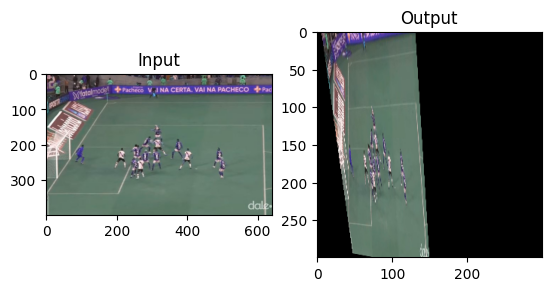

In [27]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Carregar a imagem
img = cv.imread('Vasco_Flamengo.jpg')
rows, cols, ch = img.shape

# Definir os pontos de origem e destino (apenas x, y)
pts1 = np.float32([
    [174, 81],   # Invertido de (81, 174)
    [89, 206],   # Invertido de (206, 89)
    [205, 339],  # Invertido de (339, 205)
    [425, 268]   # Invertido de (268, 425)
])
pts2 = np.float32([
    [41, 43],    # Invertido de (43, 41)
    [41, 155],   # Invertido de (155, 41)
    [72, 258],   # Invertido de (258, 72)
    [103, 207]   # Invertido de (207, 103)
])

# Calcular a matriz de homografia
M = cv.getPerspectiveTransform(pts1, pts2)

# Aplicar a transformação projetiva
dst = cv.warpPerspective(img, M, (300, 300))

# Exibir as imagens
plt.subplot(121), plt.imshow(img), plt.title('Input')
plt.subplot(122), plt.imshow(dst), plt.title('Output')
plt.show()

Compare seu resultado com o implementado no OpenCV (cv.warpAffine)

# **EXTRA**
# You are Fake News ... or maybe not.
Muitas vezes, os torcedores apaixonados pelo time desconfiam do resultado do VAR e das decisões de impedimento, como foi o caso do vídeo. Teste sua função na imagem da partida entre Union e Boca Juniors (em anexo) e verifique se o método mostrado no vídeo (https://www.instagram.com/papodeboleiros/reel/CvAhQazvuhu/) produz o mesmo resultado de impedimento que a função implementada (basta fazer a transformação na imagem com as "retas paralelas" do vídeo e verificar se de fato são paralelas). Comente sobre o resultado da comparação. Você acredita que este método seja sempre correto? Caso contrário, forneça um contraexemplo onde ele falhe (se possível, com uma imagem).


In [15]:
# Escreva seu código aqui

# My VAR-lidation
Utilizando suas funções my\_estimation e my\_transform, faça uma função que tem como entrada:

. Duas imagens, uma do jogo e uma do campo (img1,img2)

. Uma lista de pontos "fonte" e "destino"(lst1,lst2)

. Os pixels  relativos aos dois jogadores que estão sendo analisados (p1,p2)

E devolve a imagem do campo com uma linha marcada de ambos os jogadores, semelhante com as análises do VAR.

Perceba que basta desenhar uma linha (pintando todos os pixels com a mesma coordenada em x da mesma cor) quando a imagem do jogo estiver em projeção ortogonal e depois usar a inversa da matriz de projeção para voltar ao formato original.

Observação: a imagem provavelmente sofrerá perda de qualidade neste processo. Se desejar manter a qualidade, você poderá realizar esse processo apenas em uma imagem com a linha inserida e adicioná-la depois de transformada na imagem original.

In [16]:
# Escreva seu código aqui